In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
import time
import psutil
import ray
import os
import marshal
import scipy.interpolate
import types

from sklearn.linear_model import (LinearRegression, TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor)
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import curve_fit
    
from numpy.polynomial import *



In [3]:
# Params
r  = 1.025371/100 
dt = 0.5/365
T  = 180/365


LTV = 0.9
S0  = 58599.11
K   = S0 * LTV
PDL = 0.95 * S0

In [2]:
priceResults = pd.read_csv('priceResults_YouHodler.csv', index_col=0)

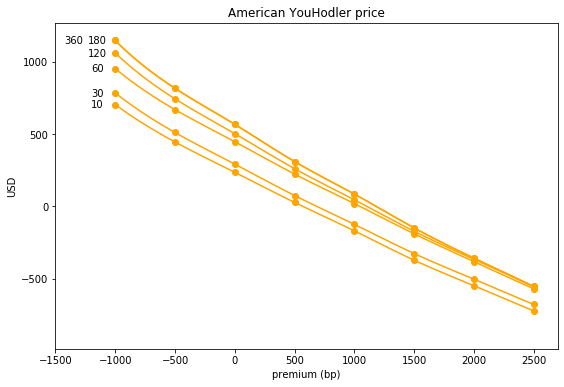

In [4]:
fill_value = 'extrapolate'

plt.figure(figsize=(9,6))
for i, endStep in enumerate([10, 30, 60, 120, 180, 360]):
    _id = priceResults.endStep == endStep

    _df = priceResults.loc[_id,:].copy()
    f = scipy.interpolate.interp1d(_df.bp, _df.AMprice, kind='cubic', fill_value=fill_value)
    bp_arr_test = np.linspace(-1000,2500,100)
    plt.scatter(_df.bp, _df.AMprice, color='orange')
    plt.plot(bp_arr_test, f(bp_arr_test), color='orange', label = 'AM price')

    plt.text(x=-1150-200*(i==5), y=_df.AMprice.iloc[0], s=endStep, va='center', ha='center')
    plt.xlim((-1500,2700))
#     plt.ylim((-1200,1200))
plt.xlabel('premium (bp)')
plt.ylabel('USD')
plt.title('American YouHodler price')
plt.savefig('americanYouHolderPrice.png', transparent=True)

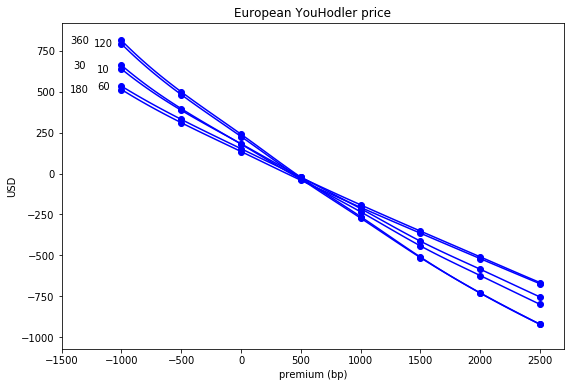

In [5]:
plt.figure(figsize=(9,6))
for i, endStep in enumerate([10, 30, 60, 120, 180, 360]):
    _id = priceResults.endStep == endStep

    _df = priceResults.loc[_id,:].copy()
    f = scipy.interpolate.interp1d(_df.bp, _df.EUprice, kind='cubic', fill_value=fill_value)
    fill_value = 'extrapolate'
    bp_arr_test = np.linspace(-1000,2500,100)
    plt.scatter(_df.bp, _df.EUprice, color='blue')
    plt.plot(bp_arr_test, f(bp_arr_test), color='blue', label = 'EU price')

    plt.text(x=-1150-200*(i%3==1)-200*(i==5), y=_df.EUprice.iloc[0], s=endStep, va='center', ha='center')
    plt.xlim((-1500,2700))
#     plt.ylim((-1200,1200))
plt.title('European YouHodler price')
plt.xlabel('premium (bp)')
plt.ylabel('USD')
plt.savefig('europeanYouHolderPrice.png', transparent=True)


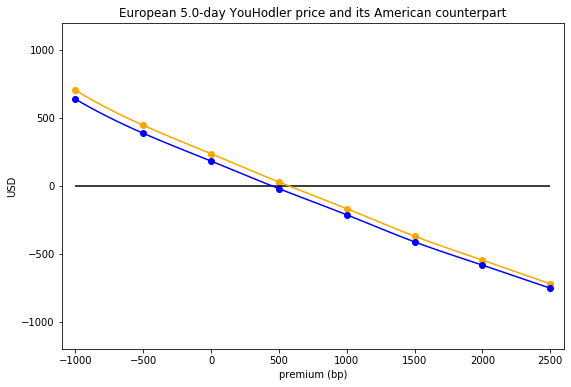

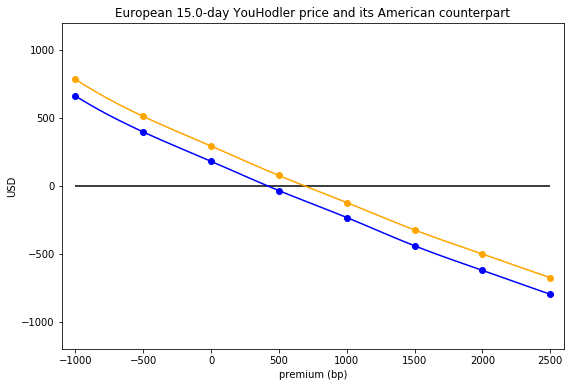

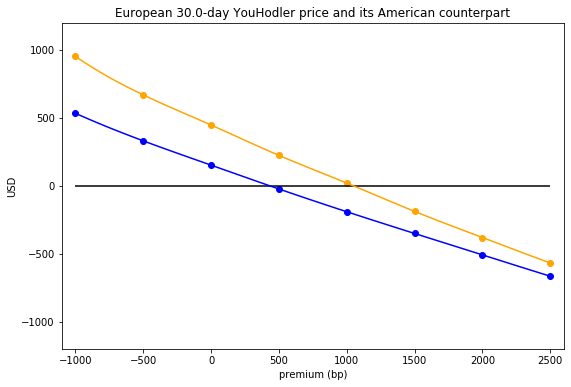

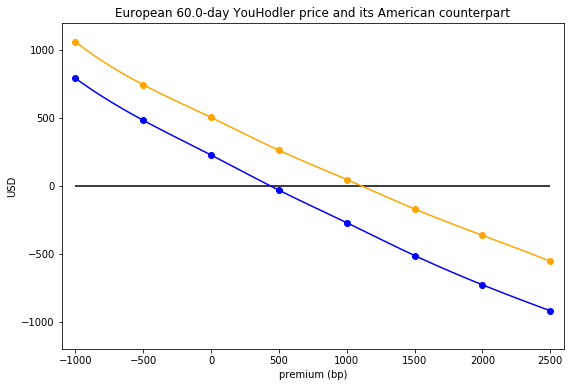

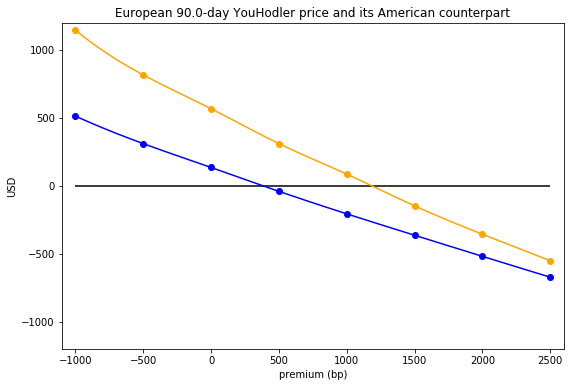

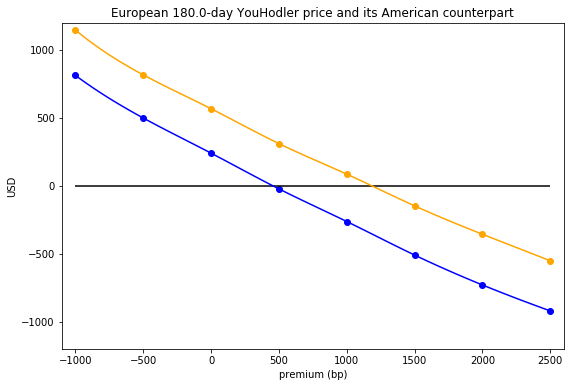

In [7]:
for endStep in [10, 30, 60, 120, 180, 360]:
    plt.figure(figsize=(9,6))

    _id = priceResults.endStep == endStep

    _df = priceResults.loc[_id,:].copy()
    f = scipy.interpolate.interp1d(_df.bp, _df.AMprice, kind='cubic', fill_value=fill_value)
    fill_value = 'extrapolate'
    bp_arr_test = np.linspace(-1000,2500,100)
    plt.scatter(_df.bp, _df.AMprice, color='orange')
    plt.plot(bp_arr_test, f(bp_arr_test), color='orange', label = 'AM price')


    f = scipy.interpolate.interp1d(_df.bp, _df.EUprice, kind='cubic', fill_value=fill_value)
    fill_value = 'extrapolate'
    plt.scatter(_df.bp, _df.EUprice, color='blue')
    plt.plot(bp_arr_test, f(bp_arr_test), color='blue', label = 'EU price')


    plt.title('European %.1f-day YouHodler price and its American counterpart'%(endStep/2))
    plt.hlines(0, xmin=-1000, xmax=2500)
    plt.xlabel('premium (bp)')
    plt.ylabel('USD')
    # plt.legend()


    f = scipy.interpolate.interp1d(_df.AMprice, _df.bp, kind='cubic', fill_value=fill_value)
    AMfairRate = f(0)

    f = scipy.interpolate.interp1d(_df.EUprice, _df.bp, kind='cubic', fill_value=fill_value)
    EUfairRate = f(0)

    plt.xlim((-1100,2600))
    plt.ylim((-1200,1200))
    plt.savefig('%.1fdayPlot.png'%(endStep/2), transparent=True)

In [8]:
endStep_arr = [i for i in range(2, 14)]


norm_q1 = scipy.stats.norm.ppf(.95)
# norm_q3 = scipy.stats.norm.ppf(.85)

AM_calibration_results = dict()
EU_calibration_results = dict()

# fill_value = - 99999

for endStep in endStep_arr:
    _id = priceResults.endStep == endStep
    bp_arr = priceResults.loc[_id,'bp']
    AMprice = priceResults.loc[_id,'AMprice']
    EUprice = priceResults.loc[_id,'EUprice']

    AM_sigma_hat = (priceResults.loc[_id,'AMprice_std'] + S0 - K)
    EU_sigma_hat = (priceResults.loc[_id,'EUprice_std'] + S0 - K)

    AM_q1 = AMprice-AM_sigma_hat*norm_q1/np.sqrt(priceResults.loc[_id,'nPaths']) 
    AM_q3 = AMprice+AM_sigma_hat*norm_q1/np.sqrt(priceResults.loc[_id,'nPaths']) 

    EU_q1 = EUprice-EU_sigma_hat*norm_q1/np.sqrt(priceResults.loc[_id,'nPaths']) 
    EU_q3 = EUprice+EU_sigma_hat*norm_q1/np.sqrt(priceResults.loc[_id,'nPaths']) 
    
    AM_f    = scipy.interpolate.interp1d(AMprice, bp_arr, kind='cubic', fill_value=fill_value)
    AM_q1_f = scipy.interpolate.interp1d(AM_q1, bp_arr, kind='cubic', fill_value=fill_value)
    AM_q3_f = scipy.interpolate.interp1d(AM_q3, bp_arr, kind='cubic', fill_value=fill_value)

    AM_calibration_results[endStep*.5] = [AM_f(0), AM_q1_f(0), AM_q3_f(0)]
    
    EU_f    = scipy.interpolate.interp1d(EUprice, bp_arr, kind='cubic', fill_value=fill_value)
    EU_q1_f = scipy.interpolate.interp1d(EU_q1, bp_arr, kind='cubic', fill_value=fill_value)
    EU_q3_f = scipy.interpolate.interp1d(EU_q3, bp_arr, kind='cubic', fill_value=fill_value)

    EU_calibration_results[endStep*.5] = [EU_f(0), EU_q1_f(0), EU_q3_f(0)]
    
AM_calibration_results = pd.DataFrame(AM_calibration_results).T/10000
AM_calibration_results.columns = ['calibrated_r', 'calibrated_upper_r', 'calibrated_lower_r']

EU_calibration_results = pd.DataFrame(EU_calibration_results).T/10000
EU_calibration_results.columns = ['calibrated_r', 'calibrated_upper_r', 'calibrated_lower_r']


# plt.plot(pd.Series(calibration_results)/10000)
# plt.scatter(calibration_results.keys(),
#             pd.Series(calibration_results)/10000)

NameError: name 'endStep_arr' is not defined

In [138]:
AM_calibration_results = AM_calibration_results.astype('float')
EU_calibration_results = EU_calibration_results.astype('float')

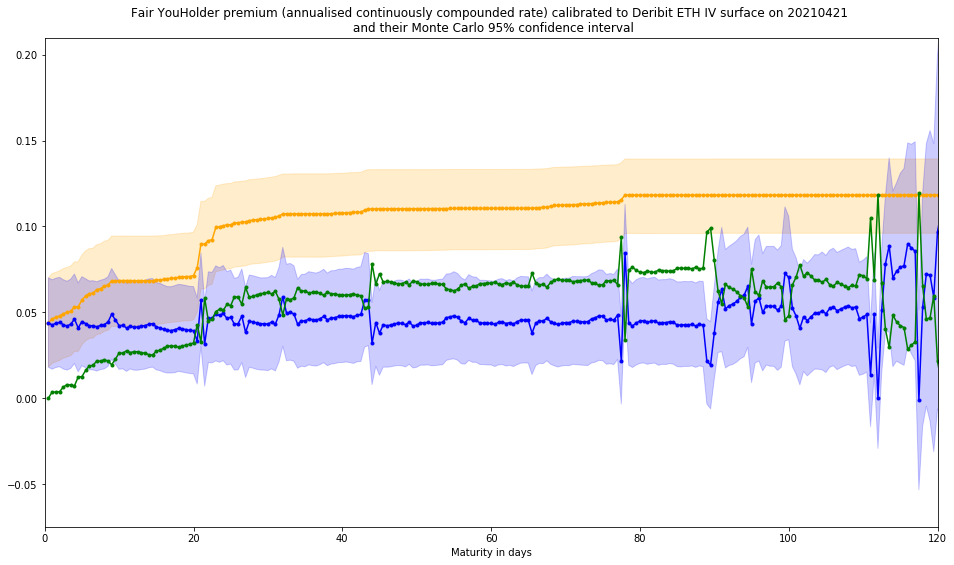

In [265]:
plt.figure(figsize=(16,9))

plt.plot(AM_calibration_results.calibrated_r, '.-', color='orange', label='AM')
# plt.scatter(AM_calibration_results.index, AM_calibration_results.calibrated_r, color=)


plt.fill_between(AM_calibration_results.index,
                 AM_calibration_results.calibrated_upper_r,
                 AM_calibration_results.calibrated_lower_r, alpha=0.2, color='orange')

plt.plot(EU_calibration_results.calibrated_r, '.-', color='blue', label='EU')
plt.fill_between(EU_calibration_results.index,
                 EU_calibration_results.calibrated_upper_r,
                 EU_calibration_results.calibrated_lower_r, alpha=0.2, color='blue')

spread = AM_calibration_results.calibrated_r - EU_calibration_results.calibrated_r
plt.plot(spread, 'g.-', label='AM-EU')

# plt.legend()
plt.xlabel('Maturity in days')
plt.title('Fair YouHolder premium (annualised continuously compounded rate) calibrated to Deribit ETH IV surface on 20210421 \n and their Monte Carlo 95% confidence interval')

plt.xlim((0,120))
plt.ylim((-0.075,.21))
plt.savefig('premiumCurve.png', transparent=True)

# plt.xlim((0,5))
# plt.plot(EU_calibration_results.calibrated_r)
# plt.plot(AM_calibration_results.calibrated_r-EU_calibration_results.calibrated_r)

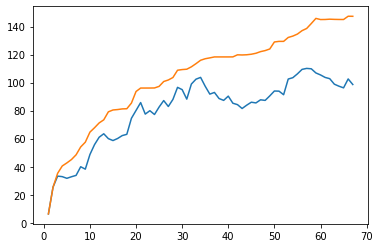

In [36]:
plt.plot(prices.endStep, prices.EUprice)
plt.plot(prices.endStep, prices.AMprice)

In [6]:
panelDataPath = '/Volumes/external_SSD/cp2pData/simulationData/20210421_YouHodler/'
p_name = 'Polynomial'
max_order = 2

endStep_arr = [i for i in range(2, 14)]
endStep_arr+= [i*7 for i in range(2,10)]
bp_arr = [0, 500, 1000, 1500, 2000, 2500]

jobs = []
for endStep in endStep_arr:
    for bp in bp_arr:
        metaDataSavePath = panelDataPath +\
                             '_'.join(['metaData',
                             p_name, str(max_order), str(bp), str(endStep),
                             ])+'.pickle'
        
        if os.path.exists(metaDataSavePath) == False:
            jobs.append([bp, endStep])
            
len(jobs)

120

In [139]:
results = ray.get([genResults_parallel.remote(p_name, max_order, 
                                              job[0], job[1],
                                              panelDataPath)\
                       for job in jobs])



(genResults_parallel pid=10854) Working on Polynomial_2_2000
(genResults_parallel pid=10864) Working on Polynomial_2_0
(genResults_parallel pid=10858) Working on Polynomial_2_2500
(genResults_parallel pid=10855) Working on Polynomial_2_2500
(genResults_parallel pid=10863) Working on Polynomial_2_1000
(genResults_parallel pid=10861) Working on Polynomial_2_500
(genResults_parallel pid=10853) Working on Polynomial_2_1000
(genResults_parallel pid=10862) Working on Polynomial_2_1500
(genResults_parallel pid=10856) Working on Polynomial_2_500
(genResults_parallel pid=10857) Working on Polynomial_2_2000
(genResults_parallel pid=10860) Working on Polynomial_2_1500
(genResults_parallel pid=10859) Working on Polynomial_2_0


KeyboardInterrupt: 

In [133]:
%%time
p_name = 'Polynomial'
max_order = 1
bp = 2000
endStep = 10
panelDataPath = '/Volumes/external_SSD/cp2pData/simulationData/20210421_YouHodler/'
resultName = p_name + '_' + str(max_order) + '_' + str(int(bp))
a = genResults(p_name, max_order, bp, endStep, panelDataPath)

Working on Polynomial_1_2000


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Poly: Polynomial; Order: 1; BP: 2000; AM price: -1.25; EU price: -69.99 
CPU times: user 4.31 s, sys: 6.54 s, total: 10.8 s
Wall time: 2min 1s


In [132]:
panelDataPath+'%ibp_panelData.pickle'%int(bp)

'/Volumes/external_SSD/cp2pData/simulationData/20210421_YouHodler/2000bp_panelData.pickle'

In [92]:
p_name = 'Polynomial'
max_order = 2

endStep_arr = [i for i in range(2, 14)]
endStep_arr+= [i*7 for i in range(2,10)]
bp_arr = [0, 500, 1000, 1500, 2000, 2500]
results = list()
for endStep in endStep_arr:
    for bp in bp_arr:
        AMprice = genResults(p_name, max_order, bp, panelDataPath, endStep)
        results.append([endStep, bp, AMprice])
        print(endStep, bp, AMprice)

Working on Polynomial_2_0
Regression is finished, AM price: 25.33775564019743
2 0 25.33775564019743
Working on Polynomial_2_500
Regression is finished, AM price: 17.53718925967405
2 500 17.53718925967405
Working on Polynomial_2_1000
Regression is finished, AM price: 9.791899018207914
2 1000 9.791899018207914
Working on Polynomial_2_1500
Regression is finished, AM price: 2.316613743729249
2 1500 2.316613743729249
Working on Polynomial_2_2000
Regression is finished, AM price: -4.810255058044277
2 2000 -4.810255058044277
Working on Polynomial_2_2500
Regression is finished, AM price: -11.166105748416157
2 2500 -11.166105748416157
Working on Polynomial_2_0
Regression is finished, AM price: 35.28857210013666
3 0 35.28857210013666
Working on Polynomial_2_500
Regression is finished, AM price: 25.108935898730124
3 500 25.108935898730124
Working on Polynomial_2_1000
Regression is finished, AM price: 15.19089870609605
3 1000 15.19089870609605
Working on Polynomial_2_1500
Regression is finished, A

KeyboardInterrupt: 

In [93]:
results = pd.DataFrame(results)
results.columns = ['endStep', 'bp', 'AMPrice']

In [94]:
import scipy.interpolate

calibration_results = dict()

for endStep in endStep_arr:
    _id = results.endStep == endStep
    bp_arr = results.loc[_id,'bp']
    AMPrice = results.loc[_id,'AMPrice']
    f = scipy.interpolate.interp1d(AMPrice, bp_arr, kind='cubic')
    calibration_results[endStep*.5]=f(0)
    
plt.plot(pd.Series(calibration_results)/10000)
plt.scatter(calibration_results.keys(),
            pd.Series(calibration_results)/10000)

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [95]:
calibration_results

{1.0: array(1658.52804815), 1.5: array(1816.19420295)}

In [68]:
pd.Series(calibration_results)

2      556.1654407074129
3      793.9690072753034
4     1246.3777690171953
5     1318.7098301061892
6      1872.984652705109
7     2206.1550880147406
8      2214.387508950206
9      2243.185476949809
10    2239.4453800918413
11    2237.4590373276124
12    2237.3081591135883
13     2286.296397363832
14    2280.3497936355166
21     2262.198718947946
28     2262.201543720289
35    2262.2070338628196
42     2262.207155533235
49    2262.2071554960935
56    2262.2071554960935
63    2262.2071554960935
dtype: object

In [16]:
filename = 'Youhodler/'+resultName+'/V1.pickle'

with open(filename, 'rb') as handle:
    V1 = pickle.load(handle)

In [17]:
np.mean(V1)-S0+K

-0.31233649711793987

In [4]:
count = 0 

variables = dict()
for p_name in poly_names:
    for max_order in [0]:
#     for max_order in order_arr:
        for bp in [0,100,200,300,400,500,600,700,800,900]:
            variables[count] = [p_name, max_order, bp]
            count+=1
            
variables = pd.DataFrame(variables).T
variables.columns = ['Polynomial', 'max_order', 'bp']
variables.loc[:, 'done'] = 0

In [5]:
variables

,Polynomial,max_order,bp,done
0,Polynomial,0,0,0
1,Polynomial,0,100,0
2,Polynomial,0,200,0
3,Polynomial,0,300,0
4,Polynomial,0,400,0
5,Polynomial,0,500,0
6,Polynomial,0,600,0
7,Polynomial,0,700,0
8,Polynomial,0,800,0
9,Polynomial,0,900,0


In [6]:
for row in variables.index:
    p_name = variables.loc[row, 'Polynomial']
    max_order = variables.loc[row, 'max_order']
    bp = variables.loc[row, 'bp']
    resultName = p_name + '_' + str(max_order) + '_' + str(int(bp))
    if os.path.exists('Youhodler/'+resultName) == False:
        os.mkdir('Youhodler/'+resultName)
    genResults(p_name, max_order, bp)
    variables.loc[row, 'done'] = 1

Working on Polynomial_0_0
Regression is finished, AM price: 182.59303432385786
Start plotting...
Done!
Working on Polynomial_0_100
Regression is finished, AM price: 152.1099589903897
Start plotting...
Done!
Working on Polynomial_0_200
Regression is finished, AM price: 122.56888343633182
Start plotting...
Done!
Working on Polynomial_0_300
Regression is finished, AM price: 93.23761315707088
Start plotting...
Done!
Working on Polynomial_0_400
Regression is finished, AM price: 65.50325254592462
Start plotting...
Done!
Working on Polynomial_0_500
Regression is finished, AM price: 39.75755269719957
Start plotting...
Done!
Working on Polynomial_0_600
Regression is finished, AM price: 17.314596607109706
Start plotting...
Done!
Working on Polynomial_0_700
Regression is finished, AM price: 3.408366317897162
Start plotting...
Done!
Working on Polynomial_0_800
Regression is finished, AM price: 0.044914974525454454
Start plotting...
Done!
Working on Polynomial_0_900
Regression is finished, AM price

In [58]:
# os.mkdir('Youhodler')
count = 0 
for p_name in poly_names:
    for max_order in order_arr:
        for bp in [0,100,200,300,400,500,600,700,800,900]:
            resultName = p_name + '_' + str(max_order) + '_' + str(int(bp))
            if os.path.exists('Youhodler/'+resultName) == False:
                os.mkdir('Youhodler/'+resultName)
            genResults(p_name, max_order, bp)